In [316]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

from collections import Counter

from mpl_toolkits.mplot3d import Axes3D

In [317]:
gals = pd.read_csv('data/r200/henriques2015a_z6p97_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')

In [24]:
import sys

import pandas as pd
import numpy as np

from collections import Counter

# https://github.com/patvarilly/periodic_kdtree
from periodic_kdtree import PeriodicCKDTree

In [25]:
import pickle as pcl

In [310]:
dgal_sfr_3p95_random = pcl.load(open('data/r200/dgal_sfr_3p95_random.pcl','rb'))
dgal_sfr_2p07_random = pcl.load(open('data/r200/dgal_sfr_2p07_random.pcl','rb'))
dgal_sfr_5p92_random = pcl.load(open('data/r200/dgal_sfr_5p92_random.pcl','rb'))

In [312]:
#dgal_stellarMass_2p07_random = pcl.load(open('data/r200/dgal_stellarMass_2p07_random.pcl','rb'))
dgal_stellarMass10_2p07_random = pcl.load(open('data/r200/dgal_stellarMass10_2p07_random.pcl','rb'))

In [247]:
print dgal_sfr_3p95_random.shape
print dgal_sfr_2p07_random.shape
print dgal_sfr_5p92_random.shape
print dgal_stellarMass_2p07_random.shape
print dgal_stellarMass10_2p07_random.shape

(3, 3, 100000, 3)
(1, 1, 100000, 3)
(1, 1, 100000, 3)
(1, 1, 100000, 3)
(1, 1, 100000, 3)


In [313]:
def plotit(ax, selection, rid, zid, clim = 0.3, plim = 0.3, N = 12):
    
    dgal = selection[rid,zid,:,0]
    completeness = selection[rid,zid,:,1]
    purity = selection[rid,zid,:,2]

    label = np.zeros(100000)

    label[(completeness >= clim) & (purity >= plim)] = 1
    label[(completeness >= clim) & (purity < plim)] = 2
    label[(completeness < clim) & (purity >= plim)] = 3
    label[(completeness < clim) & (purity < plim)] = 0
    
    binLimits = np.linspace(-1, int(np.max(dgal)+1), N)

    lower_bin = binLimits[1] + (binLimits[0]-binLimits[1])/2. 
    upper_bin = binLimits[-1] + (binLimits[0]-binLimits[1])/2.

    bins = np.linspace(lower_bin, upper_bin, N-1)

    agg_total = np.histogram(dgal, binLimits)[0]

    agg_pc = np.histogram(dgal[label==1], binLimits)[0]
    agg_pc_field = np.histogram(dgal[label==2], binLimits)[0]
    agg_pc_part = np.histogram(dgal[label==3], binLimits)[0]
    
    # set empty bins to have max protocluster probability
    agg_pc[np.where(agg_total==0)] = agg_total[np.where(agg_total==0)] = 1

    width = binLimits[2] - binLimits[1]

    ax.bar(bins, agg_pc / agg_total.astype(float), width=width, label='protocluster')

    ax.bar(bins, agg_pc_part / agg_total.astype(float), 
            width=width, bottom=agg_pc / agg_total.astype(float), label='part of a \n protocluster') 

    ax.bar(bins, agg_pc_field / agg_total.astype(float), width=width, 
            bottom=(agg_pc+agg_pc_part) / agg_total.astype(float), label='protocuster \n + field')

    ax.bar(bins, (agg_total-agg_pc-agg_pc_part-agg_pc_field) / agg_total.astype(float), width=width, 
            bottom=(agg_pc+agg_pc_field+agg_pc_part)/agg_total.astype(float), color='lightgrey', label='field')
    
    ax.set_xlim(binLimits[0], binLimits[-1])


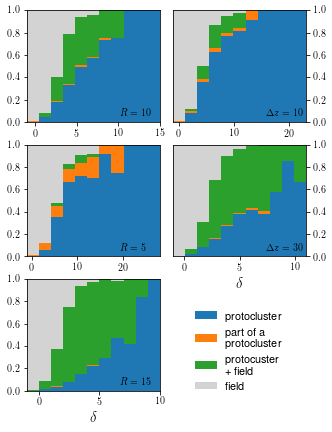

In [331]:
fig = plt.figure(figsize=(5, 7))

gs = gridspec.GridSpec(3, 2)

gs.update(wspace=0.1) # bottom = 0.57, top = 1, , wspace=0

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])

Ridx = 1
zidx = 1

# R plots
for Ridx, R, ax in zip([1,0,2], [10,5,15], [ax1,ax2,ax3]):
    plotit(ax, dgal_sfr_3p95_random, Ridx, zidx)
    ax.text(0.7,0.05,'$R = %s$'%R, transform=ax.transAxes)
    


ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[1,1])

Ridx = 1
zidx = 1

# dz plots
for zidx, deltaz, ax in zip([0,2], [5,15], [ax4,ax5]):
    plotit(ax, dgal_sfr_3p95_random, Ridx, zidx)
    ax.text(0.7,0.05,'$\Delta z = %s$'%(2*deltaz), transform=ax.transAxes)
    ax.yaxis.tick_right()


for ax in [ax3, ax5]:
    ax.set_xlabel('$\delta$', size=15)
    
legend = ax5.legend(bbox_to_anchor=(0.9, -0.4), ncol=1, prop={'size': 11})
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')

# ax5.text(0.2, -0.95, 
#          '$R = 10 \, h^{-1} \, \mathrm{cMpc}, \; \Delta z = 10 \, h^{-1} \mathrm{cMpc}$',
#          transform=ax5.transAxes, size=14)

# ax5.text(0.2, -1.15, 
#          '$z = 3.95, \; \mathrm{SFR} / M_{\odot} \mathrm{yr^{-1}} > 1$',
#          transform=ax5.transAxes, size=14)

# plt.savefig('../papers/hightolowz/images/probabilities_A.png', bbox_inches='tight', dpi=300)

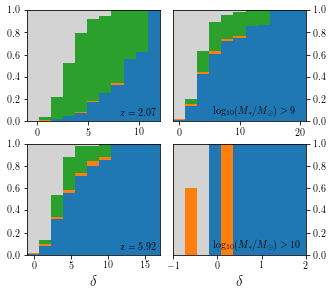

In [327]:
fig = plt.figure(figsize=(5, 4.5))

gs = gridspec.GridSpec(2, 2)

gs.update(wspace=0.1) # bottom = 0.57, top = 1, , wspace=0

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

Ridx = zidx = 0

# redshift plots
for select, z, ax in zip([dgal_sfr_2p07_random, dgal_sfr_5p92_random], [2.07,5.92], [ax1, ax2]):
    ax.text(0.7,0.05,'$z = %s$'%z, transform=ax.transAxes)
    plotit(ax, select, Ridx, zidx)
    

ax3 = fig.add_subplot(gs[0,1])
ax4 = fig.add_subplot(gs[1,1])

Ridx = zidx = 0

# selection plots
for select, sm, ax in zip([dgal_stellarMass_3p95_random, dgal_stellarMass10_2p07_random], [9,10], [ax3, ax4]):
    plotit(ax, select, Ridx, zidx)
    ax.text(0.3,0.05,'$\mathrm{log_{10}}(M_{*} / M_{\odot}) > %s$'%sm, transform=ax.transAxes)
    ax.yaxis.tick_right()
    

for ax in [ax2, ax4]:
    ax.set_xlabel('$\delta$', size=15)


# plt.savefig('../papers/hightolowz/images/probabilities_B.png', bbox_inches='tight', dpi=300)

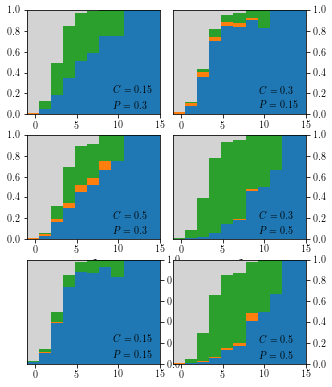

In [334]:
fig = plt.figure(figsize=(5, 6.5))

gs = gridspec.GridSpec(3, 2)

gs.update(wspace=0.1) # bottom = 0.57, top = 1, , wspace=0

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

Ridx = zidx = 1

# clim plots
for clim, ax in zip([0.15, 0.5], [ax1,ax2]):
    plotit(ax, dgal_sfr_3p95_random, Ridx, zidx, clim=clim)
    ax.text(0.65,0.2,'$C = %s$'%clim, transform=ax.transAxes)
    ax.text(0.65,0.05,'$P = 0.3$', transform=ax.transAxes)
    

ax3 = fig.add_subplot(gs[0,1])
ax4 = fig.add_subplot(gs[1,1])

Ridx = zidx = 1

# selection plots
for plim, ax in zip([0.15, 0.5], [ax3, ax4]):
    plotit(ax, dgal_sfr_3p95_random, Ridx, zidx, plim=plim)
    ax.text(0.65,0.05,'$P = %s$'%plim, transform=ax.transAxes)
    ax.text(0.65,0.2,'$C = 0.3$', transform=ax.transAxes)
    ax.yaxis.tick_right()
    

ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])

Ridx = zidx = 1

for plim, clim, ax in zip([0.15, 0.5], [0.15, 0.5], [ax5, ax6]):
    plotit(ax, dgal_sfr_3p95_random, Ridx, zidx, plim=plim, clim=clim)
    ax.text(0.65,0.05,'$P = %s$'%plim, transform=ax.transAxes)
    ax.text(0.65,0.2,'$C = %s$'%clim, transform=ax.transAxes)
    ax.yaxis.tick_right()
    
    
for ax in [ax2, ax4]:
    ax.set_xlabel('$\delta$', size=15)


# plt.savefig('../papers/hightolowz/images/probabilities_C.png', bbox_inches='tight', dpi=300)